<a href="https://colab.research.google.com/github/aparnasree2020/CAS_RPM_2023_GBM/blob/main/GCW_playcode_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [1]:
# Comment after installation so that the whole notebook can be run in one go
install.packages('gbm')
install.packages('xgboost')
install.packages('pROC')
install.packages('reshape2')


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘Rcpp’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# Get the version information
version <- R.version

# Print the version information
cat("R version", version$version.string, "\n")


R version R version 4.2.3 (2023-03-15) 


In [3]:
install.packages('shapper')
library("shapper")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gridExtra’, ‘RcppTOML’, ‘here’, ‘png’, ‘iBreakDown’, ‘ingredients’, ‘reticulate’, ‘DALEX’




In [5]:
install.packages('SHAPforxgboost')
library(SHAPforxgboost)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘htmlwidgets’, ‘httpuv’, ‘xtable’, ‘fontawesome’, ‘sourcetools’, ‘later’, ‘promises’, ‘corrplot’, ‘car’, ‘tweenr’, ‘polyclip’, ‘RcppEigen’, ‘colourpicker’, ‘miniUI’, ‘shiny’, ‘shinyjs’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘polynom’, ‘rstatix’, ‘checkmate’, ‘ggforce’, ‘ggExtra’, ‘ggpubr’, ‘BBmisc’




# Load Libraries

In [6]:
library(dplyr)
library(tidyverse)
library(xgboost)
library(gbm)
library(reshape2)
library(pROC)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.0     ✔ stringr 1.4.1
✔ tidyr   1.3.0     ✔ forcats 1.0.0
✔ readr   2.1.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loaded gbm 2.1.8.1


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from 

# Create Functions

**Actual vs Expected Plot**

The A vs E plot function here accepts the dimension variable to review along with the actual and expected response information. The graph will show the ratio of these results to weight. Input actual, expected and weight accordingly. Also, no binning takes place within the code. Please create a binned version for review before passing the information into the function where desired.

In [7]:
## avse.plot.classification includes an off balance for when the model overall predicts low or high
## this is essentially the resid.plot function used later in the regression case study
## here, actual and pred align and both are "numerators"
## in resid.plot, we pass actual loss and pred pure prem, so converting pred pure prem
## is necessary. But, I digress.
avse.plot.classification <- function(data,var,actual,pred,weight,rt_text,lt_text) {
  header = "Actual vs Predicted"

  home_plot <- data %>%
    mutate(nt = eval(parse(text = var))) %>%
    group_by(nt) %>%
    summarize(  act = sum(eval(parse(text = actual)))
                , pred = sum(eval(parse(text = pred)))
                , exposures = sum(eval(parse(text = weight)))
    ) %>%
    mutate(   actual = act/exposures
              , predicted = pred/exposures)
  
  home_plot <- home_plot[complete.cases(home_plot),]
  
  # off balance for model total prediction
  a1 = paste0("data$",actual)
  a2 = paste0("data$",pred)
  off_balance = sum(eval(parse(text = a1)))/sum(eval(parse(text = a2)))
  home_plot$predicted <- home_plot$predicted*off_balance
  
  par(mar=c(5, 4, 2, 5) + 0.1)
  
  barplot(home_plot$exposures,las=2,col="lightblue",ylim = c(0,max(home_plot$exposures)*1.1))
  par(new=TRUE)
  plot(home_plot$nt, home_plot$actual, col='darkblue',lwd= 4, axes=FALSE, ylim=c(ifelse(min(home_plot$actual)<min(home_plot$predicted),min(home_plot$actual)*0.98,min(home_plot$predicted)*0.98),ifelse(max(home_plot$actual)>max(home_plot$predicted),max(home_plot$actual)*1.02,max(home_plot$predicted)*1.02)), xlab="", ylab="",main=header)
  axis(4, ylim=c(0,1),col="black",las=1)
  axis(1, xlim=c(0,1),col="black",las=1)
  mtext(rt_text,side=4,line=3.0,col="black",font=7)
  mtext(lt_text, side = 2, line=3.0,col="black",font=7)
  box()
  mtext(var,side=1,col="black",line=2.5,font=7) 
  lines(home_plot$nt,home_plot$predicted, col="green",lwd=3)  
}


# Simulate Data - A More Interesting Example

Now, we're going to take the xgboost for a test drive. Our simulated example above is nice for an introduction, but is too trivial for deeper play. Let's put something together a bit closer to what we would typically run.

For explorations, we will create the following data:
*   Age
*   Gender (y-correlated with Age)
*   Marital Status (exposure correlated with Age)
*   Tenure (some correlation with age)
*   Territory (Urban and Rural)
*   Vehicle Type (Sedan, Minivan, Trucks, Other - some correlation with Marital Status and Territory)
*   V1 - V9 (9 generic variables of various correlations with each other and with response)


In [8]:
sim_file_github <- "https://raw.github.com/aparnasree2020/sampledata_casws/master/Sim_Data_CASRPM2023.csv"
df <- read.csv(file=sim_file_github, header=TRUE)


In [9]:
#A space to look at the data
summary(df)

     x.Age         x.Gender.M    x.MaritalStatus.M    x.Tenure     
 Min.   :16.00   Min.   :0.000   Min.   :0.0000    Min.   : 0.000  
 1st Qu.:36.00   1st Qu.:0.000   1st Qu.:0.0000    1st Qu.: 2.000  
 Median :53.00   Median :0.000   Median :1.0000    Median : 5.000  
 Mean   :53.02   Mean   :0.499   Mean   :0.5495    Mean   : 6.024  
 3rd Qu.:70.00   3rd Qu.:1.000   3rd Qu.:1.0000    3rd Qu.: 9.000  
 Max.   :90.00   Max.   :1.000   Max.   :1.0000    Max.   :20.000  
 x.Territory.U         x.V1             x.V2            x.V3     
 Min.   :0.0000   Min.   : 1.000   Min.   : 1.00   Min.   : 1.0  
 1st Qu.:0.0000   1st Qu.: 3.000   1st Qu.: 3.00   1st Qu.: 7.0  
 Median :0.0000   Median : 6.000   Median : 5.00   Median :11.0  
 Mean   :0.2005   Mean   : 5.506   Mean   : 5.49   Mean   :10.5  
 3rd Qu.:0.0000   3rd Qu.: 8.000   3rd Qu.: 8.00   3rd Qu.:14.0  
 Max.   :1.0000   Max.   :10.000   Max.   :10.00   Max.   :20.0  
      x.V4             x.V5             x.V6           x.V7   

In [10]:
set.seed(031303)
sample <- sample(c(TRUE, FALSE), nrow(df), replace=TRUE, prob=c(0.8,0.2))
df.train  <- df[sample, ]
df.test   <- df[!sample, ]

In [11]:
x.train <- df.train[,!names(df.train) %in% c("y.truth", "y.out")]
y.train <- df.train[,names(df.train) %in% "y.out"]
truth.train <- df.train[,names(df.train) %in% "y.truth"]
df.train$exposures <- 1

x.test <- df.test[,!names(df.test) %in% c("y.truth", "y.out")]
y.test <- df.test[,names(df.test) %in% "y.out"]
truth.test <- df.test[,names(df.test) %in% "y.truth"]
df.test$exposures <- 1

**Quick Look at the Data**

It's good to take a look at the data and see what we think about what we have.

In [12]:
colnames(df.train)

[1] "x.Age"                 "x.Gender.M"            "x.MaritalStatus.M"    
 [4] "x.Tenure"              "x.Territory.U"         "x.V1"                 
 [7] "x.V2"                  "x.V3"                  "x.V4"                 
[10] "x.V5"                  "x.V6"                  "x.V7"                 
[13] "x.V8"                  "x.V9"                  "x.VehicleType.Sedan"  
[16] "x.VehicleType.Minivan" "x.VehicleType.Pickup"  "x.VehicleType.Other"  
[19] "y.truth"               "y.out"                 "exposures"

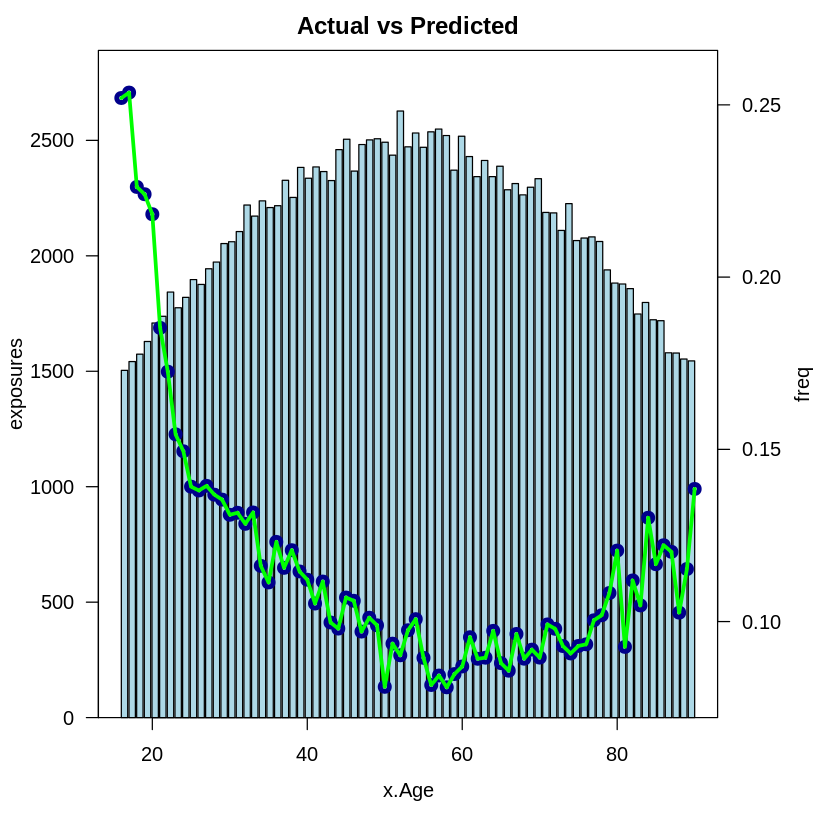

In [13]:
avse.plot.classification(var="x.Age",data=df.train,actual="y.out",pred="y.out",weight="exposures",lt_text="exposures",rt_text="freq")

In [14]:

m.xgb <- xgboost(data = as.matrix(x.train),
                  label = y.train,
                  verbose = 0,
                  nrounds = 100,                  #number of trees, defaulat is 100
                  eta = 0.3,                      #learning rate, default is 0.3
                  max_depth = 6,                  #depth of tree, default is 6
                  subsample = 1,                  #sample of data used for each iteration, default is 1
                  colsample_bytree = 1,           #pct of features for each iteration, default is 1
                  objective = "binary:logistic")  #prediction objective

y.pred.train <- predict(m.xgb, newdata=as.matrix(x.train), type="response")
y.pred.test <- predict(m.xgb, newdata=as.matrix(x.test), type="response")

In [15]:
df.train$y.pred.xgb <- y.pred.train
df.test$y.pred.xgb <- y.pred.test

Let's take a look at how we did.

**Lift Table**

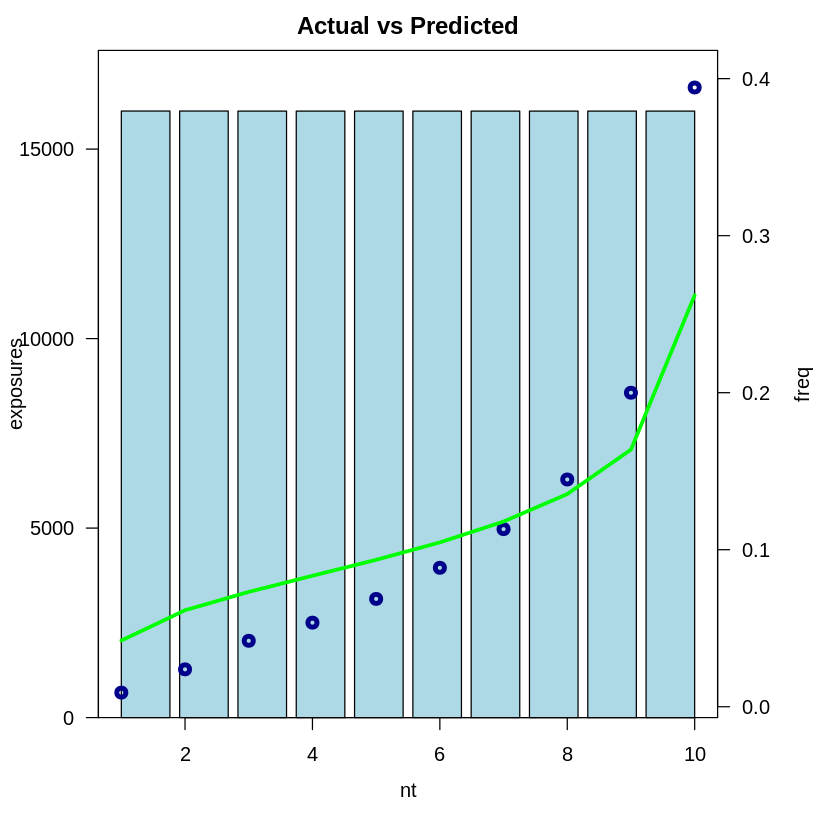

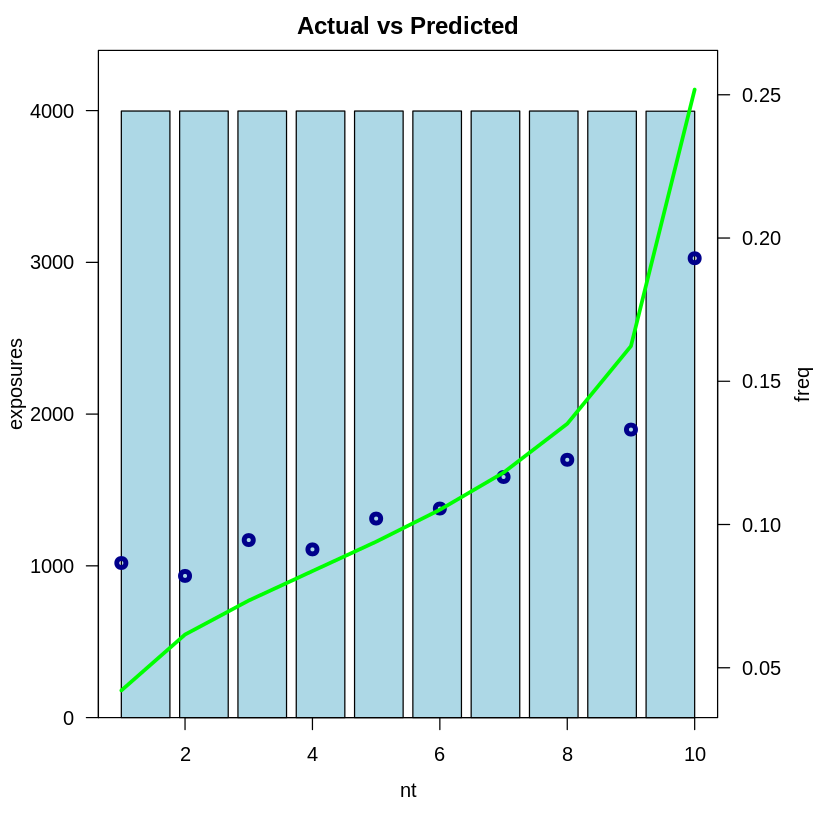

In [16]:
df.train <- df.train %>%
  mutate(nt = ntile(y.pred.xgb, 10))
avse.plot.classification(var="nt",data=df.train,actual="y.out",pred="y.pred.xgb",weight="exposures",lt_text="exposures",rt_text="freq")

df.test <- df.test %>%
  mutate(nt = ntile(y.pred.xgb, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.xgb",weight="exposures",lt_text="exposures",rt_text="freq")

**ROC, AUC and GINI**

We're going to use/stack the statline info repeatedly. This is a good time to make that a function.

In [17]:
build_statline = function(y.train, y.train.pred, y.test, y.test.pred, model.name) {
  quiet.setting <- TRUE
  model.train.auc <- c(auc(y.train, y.train.pred, quiet = quiet.setting))
  model.train.gini <- 2*model.train.auc - 1
  model.test.auc <- c(auc(y.test, y.test.pred, quiet = quiet.setting))
  model.test.gini <- 2*model.test.auc - 1
  return(data.frame(model.name, model.train.auc, model.train.gini, model.test.auc, model.test.gini))
}

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



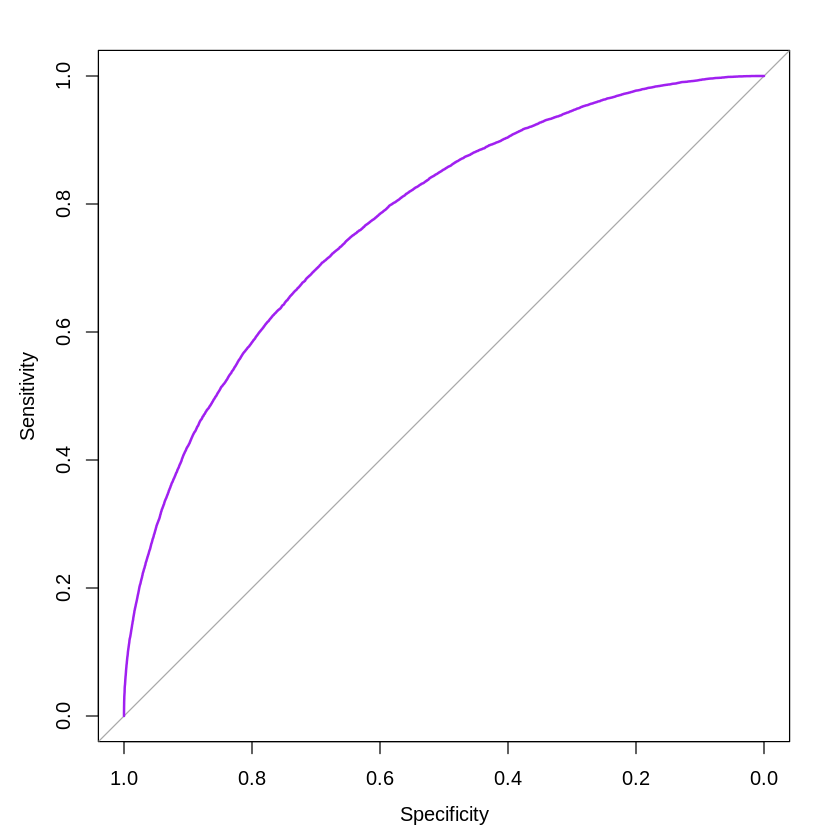

model.name model.train.auc model.train.gini model.test.auc model.test.gini
1 XGB        0.7747078       0.5494156        0.5787829      0.1575658

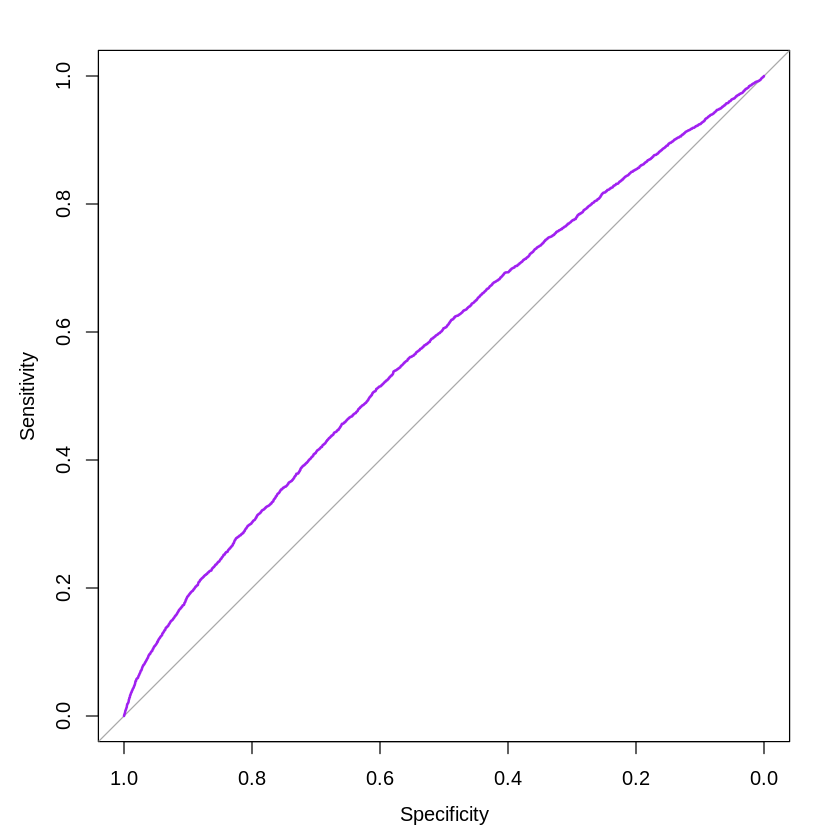

In [18]:
roc.score.train.xgb <- roc(y.train, df.train$y.pred.xgb)
plot(roc.score.train.xgb, col = "purple", add = FALSE)

roc.score.test.xgb <- roc(y.test, df.test$y.pred.xgb)
plot(roc.score.test.xgb, col = "purple", add = FALSE)

statline.xgb <- build_statline(y.train, df.train$y.pred.xgb, y.test, df.test$y.pred.xgb, "XGB")
statline.xgb

**A vs E plots**

In [19]:
colnames(df.train)

[1] "x.Age"                 "x.Gender.M"            "x.MaritalStatus.M"    
 [4] "x.Tenure"              "x.Territory.U"         "x.V1"                 
 [7] "x.V2"                  "x.V3"                  "x.V4"                 
[10] "x.V5"                  "x.V6"                  "x.V7"                 
[13] "x.V8"                  "x.V9"                  "x.VehicleType.Sedan"  
[16] "x.VehicleType.Minivan" "x.VehicleType.Pickup"  "x.VehicleType.Other"  
[19] "y.truth"               "y.out"                 "exposures"            
[22] "y.pred.xgb"            "nt"

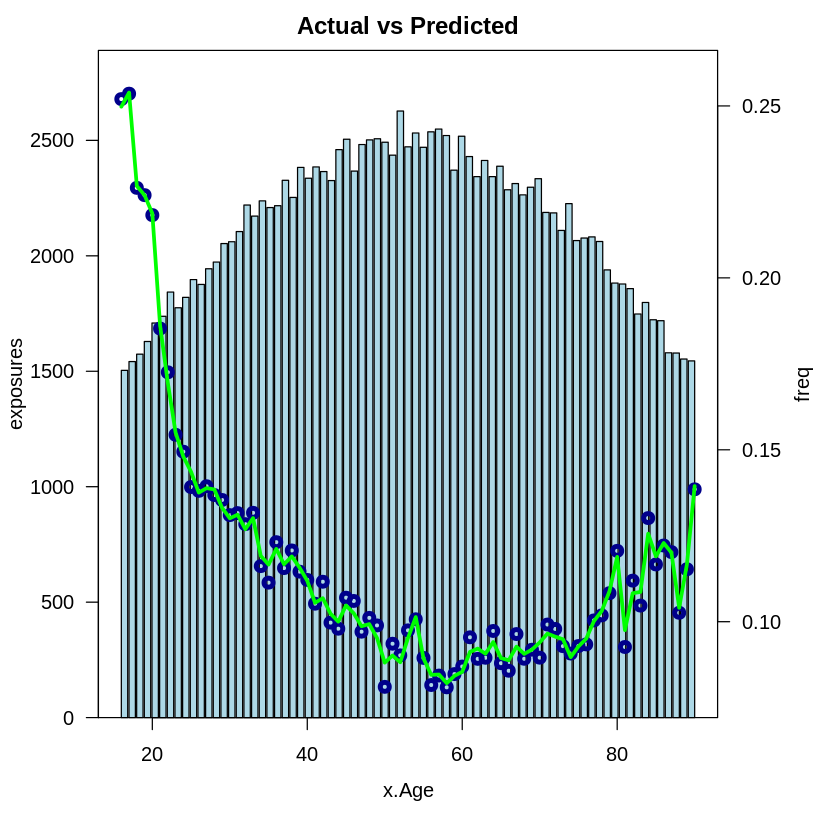

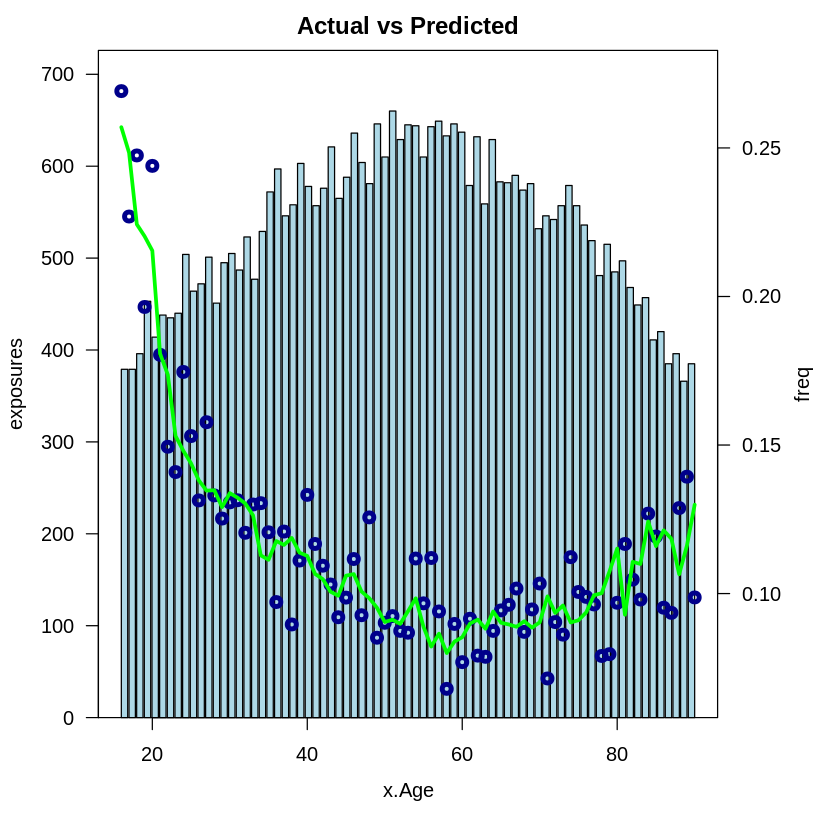

In [20]:
var.curr = "x.Age"
avse.plot.classification(var=var.curr,data=df.train,actual="y.out",pred="y.pred.xgb",weight="exposures",lt_text="exposures",rt_text="freq")
avse.plot.classification(var=var.curr,data=df.test,actual="y.out",pred="y.pred.xgb",weight="exposures",lt_text="exposures",rt_text="freq")

**Variable Importance**
With more variables, now it is interesting to consider what the model says are the important variables. And the package supplies a view for us.

In [21]:
importance_matrix <- xgb.importance(colnames(x.train), model = m.xgb)
importance_matrix

Feature               Gain        Cover       Frequency  
1  x.Age                 0.206969339 0.196372024 0.142663733
2  x.Tenure              0.091832597 0.127214970 0.092570655
3  x.V3                  0.084368087 0.098333824 0.095616856
4  x.V9                  0.079863668 0.083081161 0.093078355
5  x.V6                  0.075077038 0.082567880 0.087324420
6  x.V1                  0.072670973 0.059572536 0.077170418
7  x.V2                  0.064316656 0.058167026 0.067524116
8  x.V4                  0.058679294 0.054792792 0.067354882
9  x.V8                  0.058395813 0.048953690 0.069216449
10 x.V7                  0.051630717 0.048470900 0.063462515
11 x.V5                  0.047278746 0.045022365 0.052462346
12 x.Gender.M            0.030248663 0.013190639 0.017431037
13 x.Territory.U         0.025129768 0.028689309 0.016754104
14 x.VehicleType.Other   0.012303762 0.011632130 0.012015569
15 x.MaritalStatus.M     0.012275016 0.018951109 0.011846336
16 x.VehicleType.Pickup  0.010301779 0.013381113 0.011677103
17 x.VehicleType.Sedan   0.009801869 0.007895118 0.011846336
18 x.VehicleType.Minivan 0.008856214 0.003711413 0.009984769

Before we move on to playing (hypertuning) and improving our GBM, let's take a moment and see where our GLM starting point is. If you get annoyed by the warning below you'll want to remove one of the VehicleType variables.

In [22]:
m.glm <- glm(y.train ~ ., x.train, family=binomial(link='logit'))
df.train$y.pred.glm <- predict(m.glm, newdata=x.train, type="response")
df.test$y.pred.glm <- predict(m.glm, newdata=x.test, type="response")
summary(m.glm)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”



Call:
glm(formula = y.train ~ ., family = binomial(link = "logit"), 
    data = x.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8332  -0.5260  -0.4645  -0.4023   2.5641  

Coefficients: (1 not defined because of singularities)
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -1.9664637  0.0514086 -38.252  < 2e-16 ***
x.Age                 -0.0068577  0.0004608 -14.881  < 2e-16 ***
x.Gender.M             0.1214298  0.0158618   7.656 1.93e-14 ***
x.MaritalStatus.M     -0.2109414  0.0205605 -10.260  < 2e-16 ***
x.Tenure              -0.0330195  0.0016497 -20.015  < 2e-16 ***
x.Territory.U          0.3066902  0.0191634  16.004  < 2e-16 ***
x.V1                   0.0365721  0.0027620  13.241  < 2e-16 ***
x.V2                   0.0259867  0.0037286   6.970 3.18e-12 ***
x.V3                   0.0078966  0.0025022   3.156   0.0016 ** 
x.V4                   0.0121679  0.0027608   4.407 1.05e-05 ***
x.V5                   0.

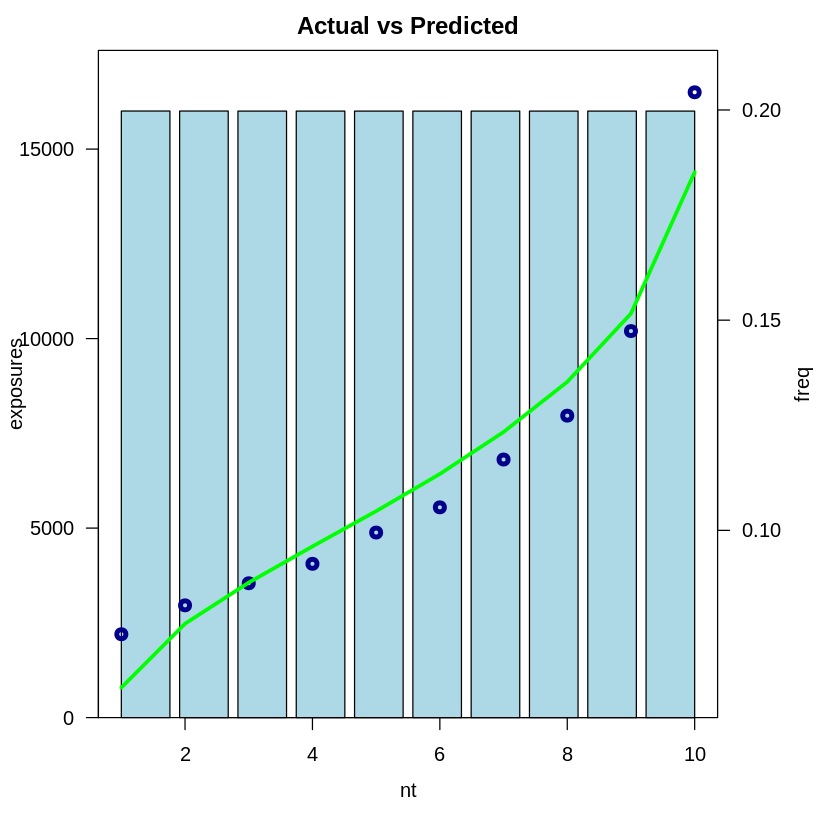

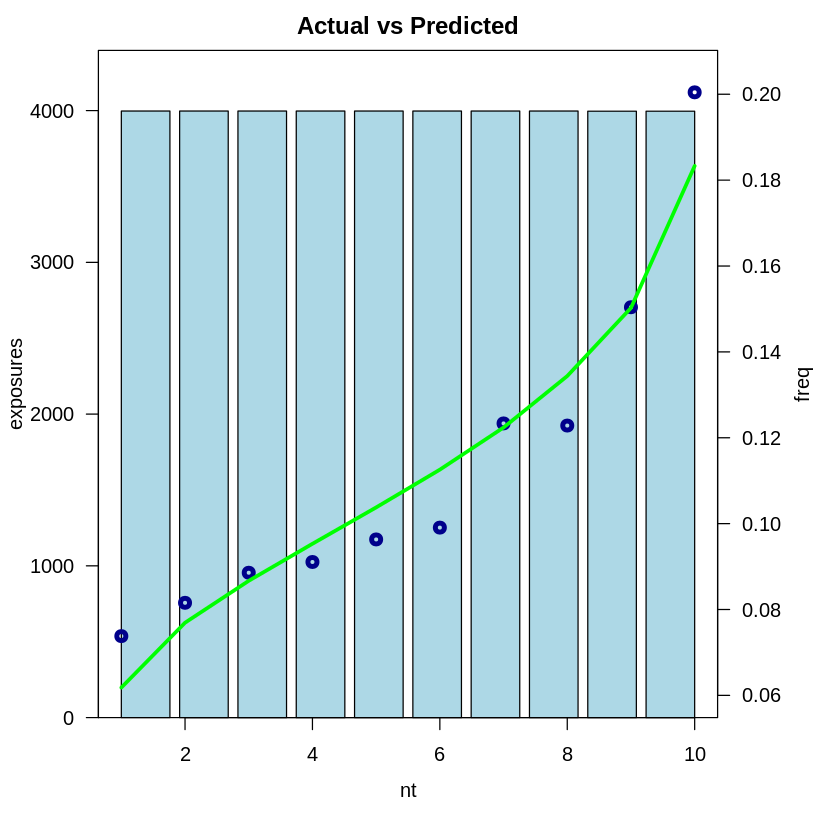

In [23]:
df.train <- df.train %>%
  mutate(nt = ntile(y.pred.glm, 10))
avse.plot.classification(var="nt",data=df.train,actual="y.out",pred="y.pred.glm",weight="exposures",lt_text="exposures",rt_text="freq")

df.test <- df.test %>%
  mutate(nt = ntile(y.pred.glm, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.glm",weight="exposures",lt_text="exposures",rt_text="freq")

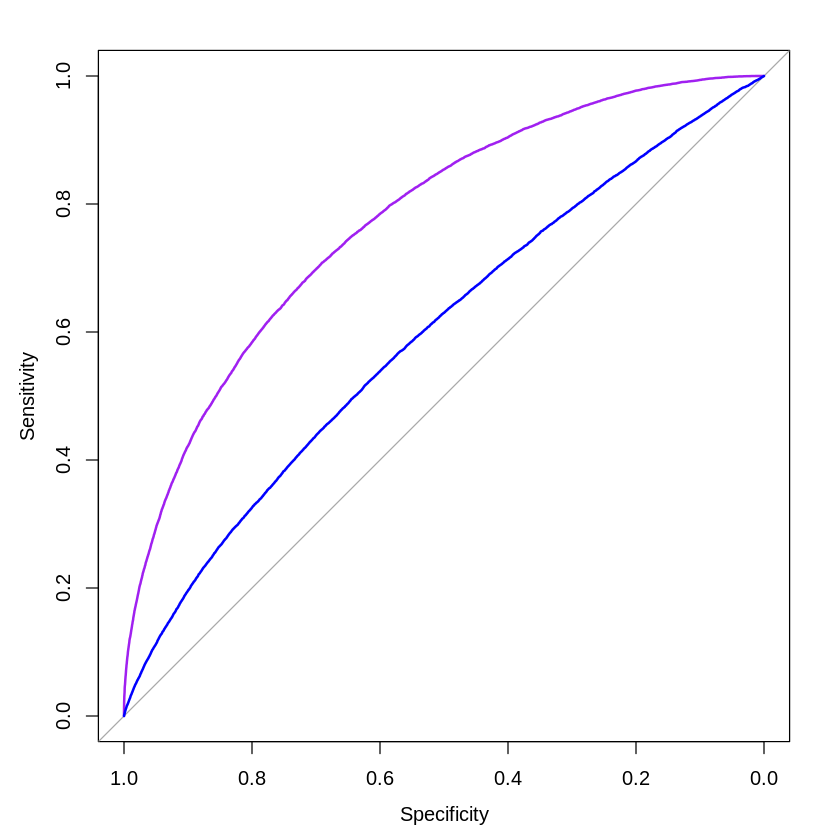

model.name model.train.auc model.train.gini model.test.auc model.test.gini
1 GLM        0.5957808       0.1915615        0.5966333      0.1932665      
2 XGB        0.7747078       0.5494156        0.5787829      0.1575658

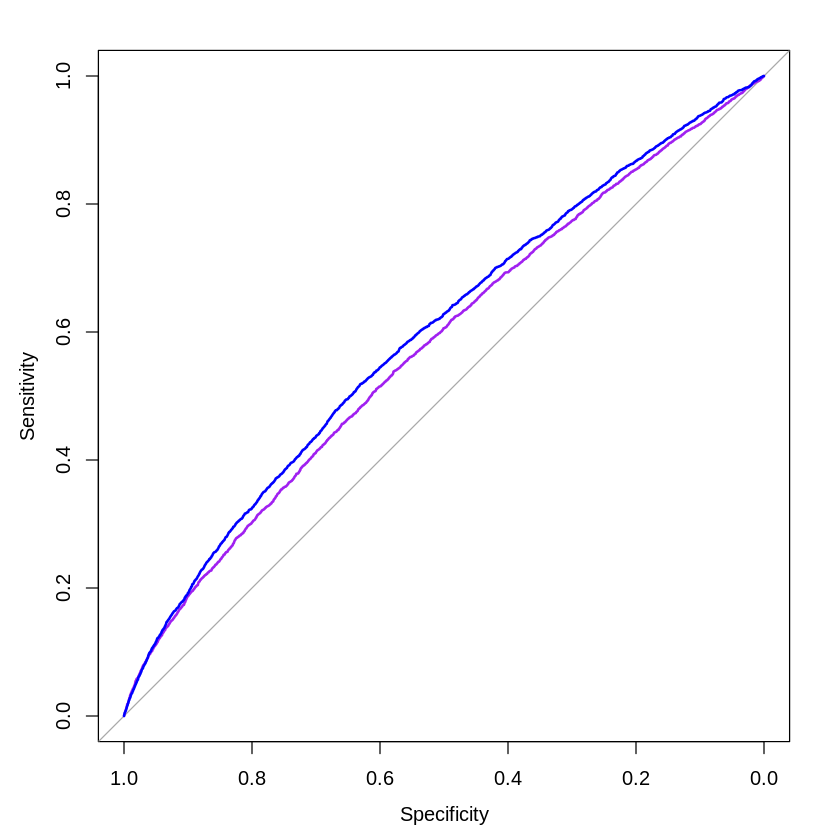

In [24]:
quiet.setting = TRUE
roc.score.xgb <- roc(y.train, df.train$y.pred.xgb, quiet = quiet.setting)
roc.score.glm <- roc(y.train, df.train$y.pred.glm, quiet = quiet.setting)
plot(roc.score.xgb, col = "purple", add = FALSE)
plot(roc.score.glm, col = "blue", add = TRUE)

roc.score.xgb <- roc(y.test, df.test$y.pred.xgb, quiet = quiet.setting)
roc.score.glm <- roc(y.test, df.test$y.pred.glm, quiet = quiet.setting)
plot(roc.score.xgb, col = "purple", add = FALSE)
plot(roc.score.glm, col = "blue", add = TRUE)

statline.glm <- build_statline(y.train, df.train$y.pred.glm, y.test, df.test$y.pred.glm, "GLM")
statline.all <- rbind(statline.glm, statline.xgb)
statline.all

In [25]:
colnames(x.train)

[1] "x.Age"                 "x.Gender.M"            "x.MaritalStatus.M"    
 [4] "x.Tenure"              "x.Territory.U"         "x.V1"                 
 [7] "x.V2"                  "x.V3"                  "x.V4"                 
[10] "x.V5"                  "x.V6"                  "x.V7"                 
[13] "x.V8"                  "x.V9"                  "x.VehicleType.Sedan"  
[16] "x.VehicleType.Minivan" "x.VehicleType.Pickup"  "x.VehicleType.Other"

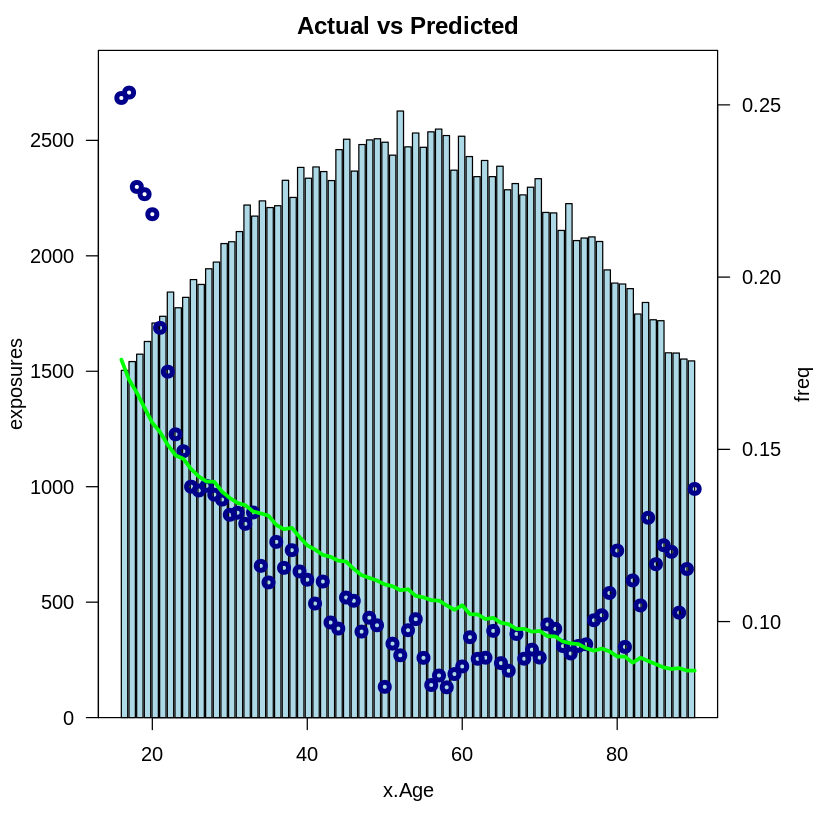

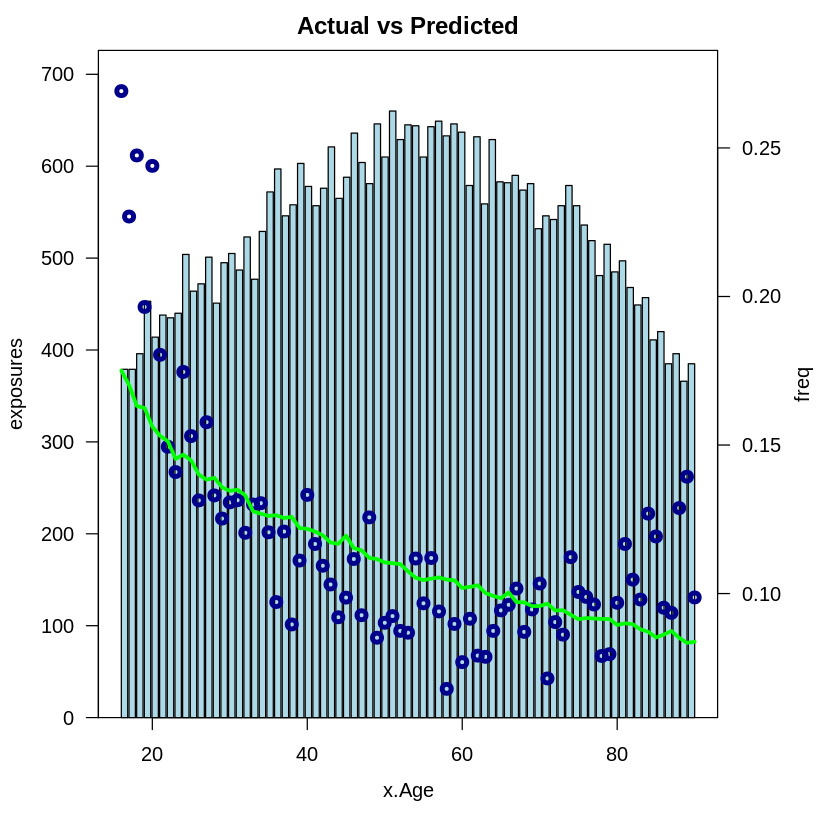

In [26]:
var.curr = "x.Age"
avse.plot.classification(var=var.curr,data=df.train,actual="y.out",pred="y.pred.glm",weight="exposures",lt_text="exposures",rt_text="freq")
avse.plot.classification(var=var.curr,data=df.test,actual="y.out",pred="y.pred.glm",weight="exposures",lt_text="exposures",rt_text="freq")

# Improve on the GBM - Hyperparameters and Tuning

We can improve on the GLM, but we won't. What we will do here is improve on this preliminary XGBoost, ideally without too much additional work.

In [27]:
params = list(eta=0.3,
  max_depth=6,
  subsample=1,
  colsample_bytree=1)
xgb.cv.out <- xgb.cv(params = params,
  data = as.matrix(x.train),
  label = y.train,
  objective = "binary:logistic",
  nrounds = 100,
  nfold = 5,
  showsd = TRUE,
  print_every_n = 10,
  early_stop_round = 20)

[1]	train-logloss:0.538676+0.000585	test-logloss:0.539213+0.001150 
[11]	train-logloss:0.341002+0.001429	test-logloss:0.347268+0.005560 
[21]	train-logloss:0.334859+0.001582	test-logloss:0.347652+0.005749 
[31]	train-logloss:0.329931+0.001566	test-logloss:0.348624+0.005694 
[41]	train-logloss:0.325382+0.001587	test-logloss:0.349437+0.005830 
[51]	train-logloss:0.321188+0.001981	test-logloss:0.350361+0.005980 
[61]	train-logloss:0.316979+0.002164	test-logloss:0.351231+0.005972 
[71]	train-logloss:0.313060+0.002274	test-logloss:0.352077+0.005971 
[81]	train-logloss:0.309216+0.002208	test-logloss:0.353000+0.005939 
[91]	train-logloss:0.305477+0.002373	test-logloss:0.353873+0.006008 
[100]	train-logloss:0.302317+0.002163	test-logloss:0.354600+0.006057 


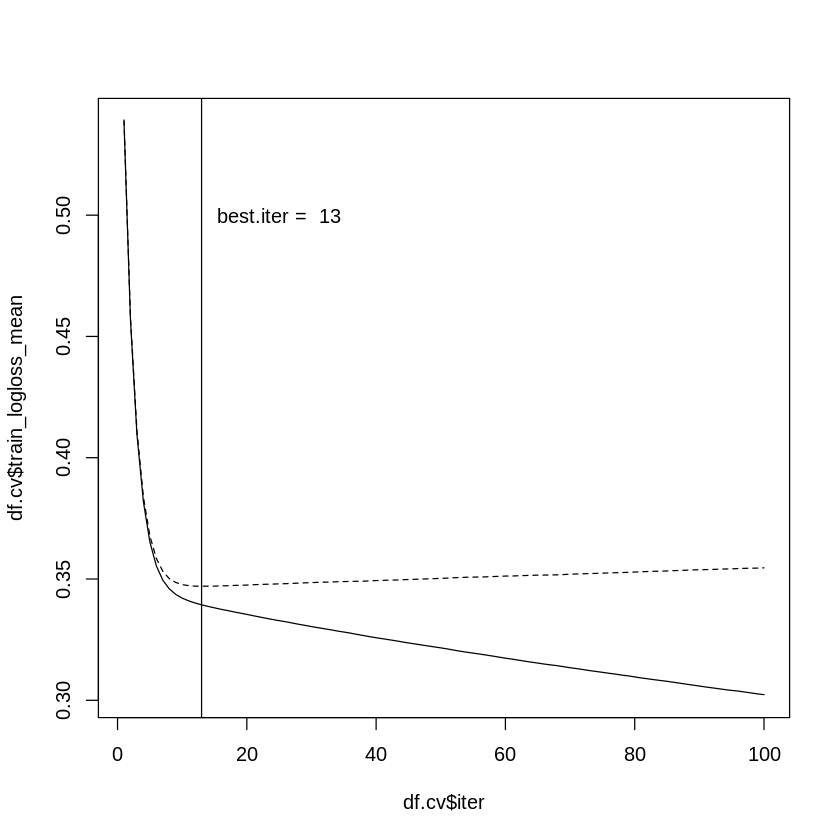

In [28]:
df.cv <- xgb.cv.out$evaluation_log
plot(df.cv$iter, df.cv$train_logloss_mean, type = "l", lty=1)
lines(df.cv$iter, df.cv$test_logloss_mean, lty=2)
best.iter <- df.cv$iter[df.cv$test_logloss_mean == min(df.cv$test_logloss_mean)]
abline(v=best.iter)
text(25, 0.5, paste("best.iter = ", best.iter))

In [29]:
m.xgb2 <- xgboost(params = params,
  data = as.matrix(x.train),
  label = y.train,
  objective = "binary:logistic",
  nrounds = 14,
  verbose = 0)
df.train$y.pred.xgb2 <- predict(m.xgb2, newdata=as.matrix(x.train), type="response")
df.test$y.pred.xgb2 <- predict(m.xgb2, newdata=as.matrix(x.test), type="response")

In [30]:
statline.xgb2 <- build_statline(y.train, df.train$y.pred.xgb2, y.test, df.test$y.pred.xgb2, "XGB2")
statline.all <- rbind(statline.glm, statline.xgb, statline.xgb2)
statline.all

model.name model.train.auc model.train.gini model.test.auc model.test.gini
1 GLM        0.5957808       0.1915615        0.5966333      0.1932665      
2 XGB        0.7747078       0.5494156        0.5787829      0.1575658      
3 XGB2       0.6450874       0.2901748        0.5982444      0.1964888

In [31]:
xgb.importance(colnames(x.train), model = m.xgb2)

Feature               Gain        Cover       Frequency  
1  x.Age                 0.355537997 0.291192100 0.138761468
2  x.Tenure              0.097194057 0.175859987 0.094036697
3  x.V1                  0.080319562 0.087680136 0.118119266
4  x.Gender.M            0.061044722 0.019084509 0.021788991
5  x.V2                  0.059189840 0.075761768 0.086009174
6  x.Territory.U         0.056931390 0.114963113 0.045871560
7  x.V3                  0.052462447 0.050727151 0.086009174
8  x.V6                  0.045779611 0.030837238 0.079128440
9  x.V4                  0.038152950 0.021633403 0.072247706
10 x.V8                  0.028910278 0.010674164 0.055045872
11 x.V9                  0.028862064 0.017813037 0.051605505
12 x.V5                  0.023154465 0.009963749 0.040137615
13 x.V7                  0.020359522 0.006874888 0.040137615
14 x.VehicleType.Other   0.019085484 0.039475431 0.026376147
15 x.MaritalStatus.M     0.016727250 0.029615322 0.018348624
16 x.VehicleType.Pickup  0.009647580 0.013055997 0.013761468
17 x.VehicleType.Sedan   0.003490662 0.001973537 0.006880734
18 x.VehicleType.Minivan 0.003150118 0.002814469 0.005733945

#SHAP 

Here we are computing the SHAP values using the shap package "('SHAPforxgboost'".) 

Note: the R package Shap didn't work with the specific version in colab. 

## Partial dependence plot (PDP) 

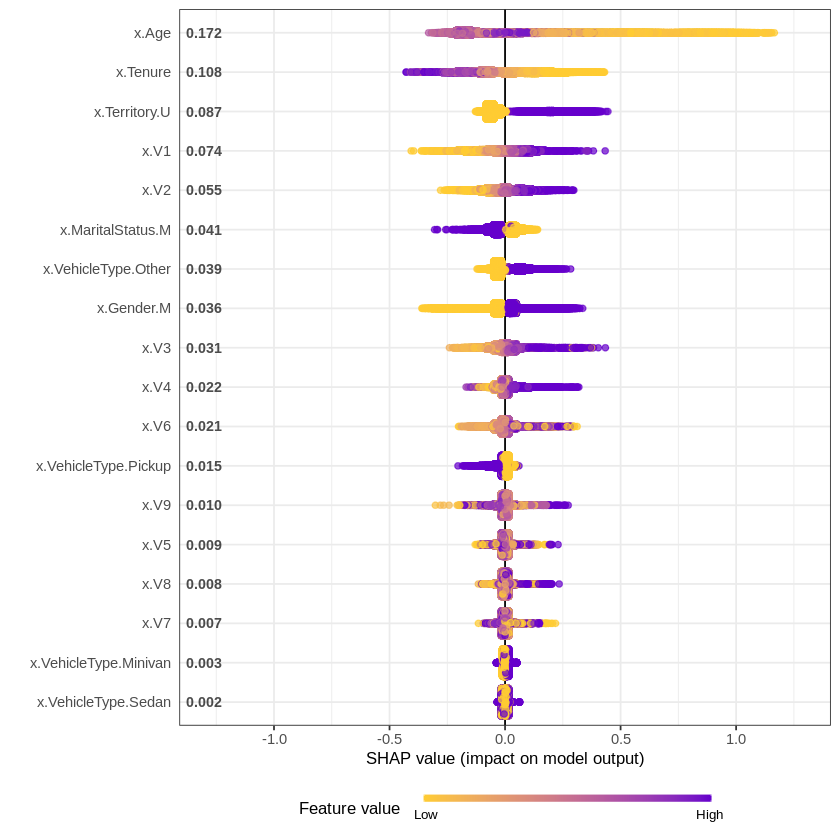

In [33]:
dtrain = as.matrix(x.train)
shap <- shap.prep(m.xgb2, X_train = dtrain)
#SHAP importance
shap.plot.summary(shap)

In [35]:
# These are the top 3 features
imp_vars <- shap.importance(shap, top_n = 3, names_only = TRUE)
print(imp_vars)

[1] "x.Age"         "x.Tenure"      "x.Territory.U"


`geom_smooth()` using formula = 'y ~ x'


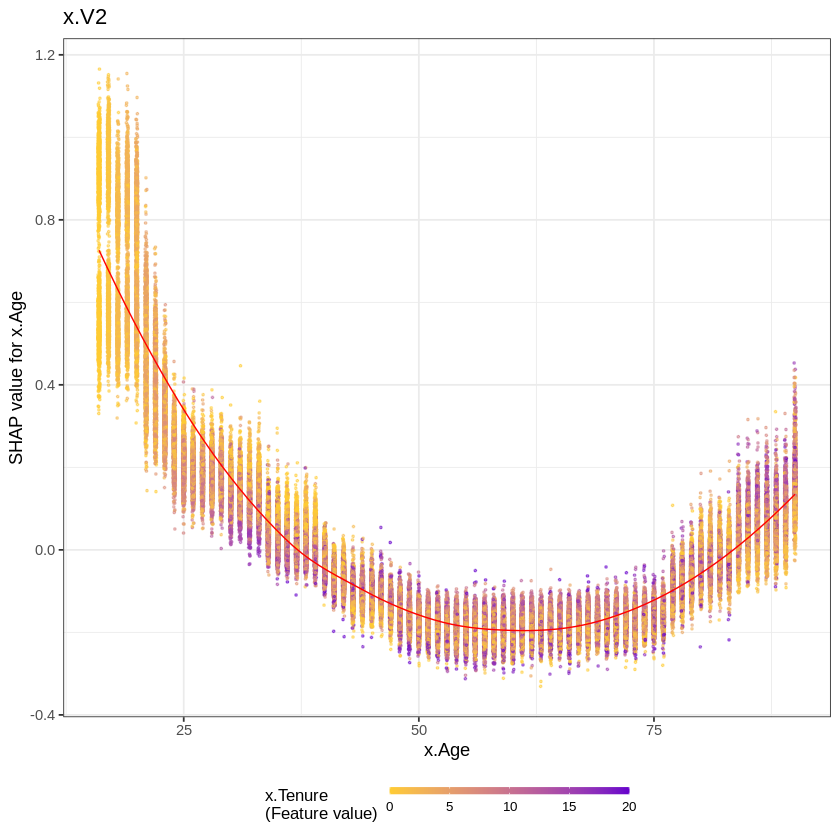

In [36]:
 # Here I am plotting the top feature bins, its shap value in Y axis ( red) and the second important feature in color
  p <- shap.plot.dependence(shap, "x.Age", color_feature = "x.Tenure", 
                            alpha = 0.5, jitter_width = 0.1) +
    ggtitle(v)
  print(p)

In [40]:
# compute SHAP values
shap.
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
inds = shap.approximate_interactions("x.Age", shap_values, X)


ERROR: ignored

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


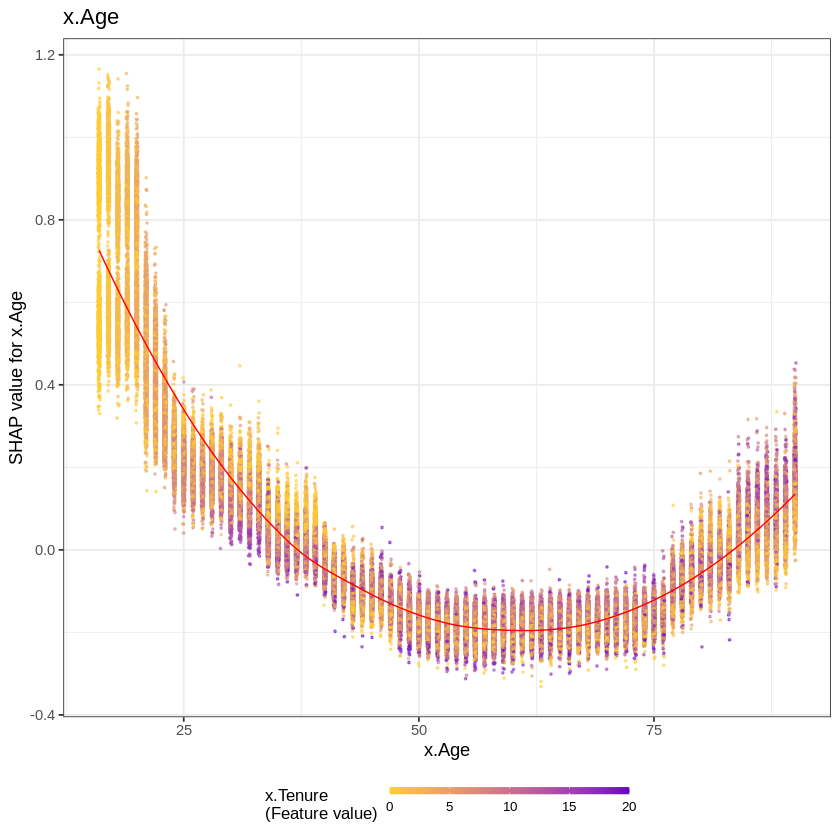

`geom_smooth()` using formula = 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“at  -0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“radius  2.5e-05”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“all data on boundary of neighborhood. make span bigger”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  1”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1.01”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“zero-wid

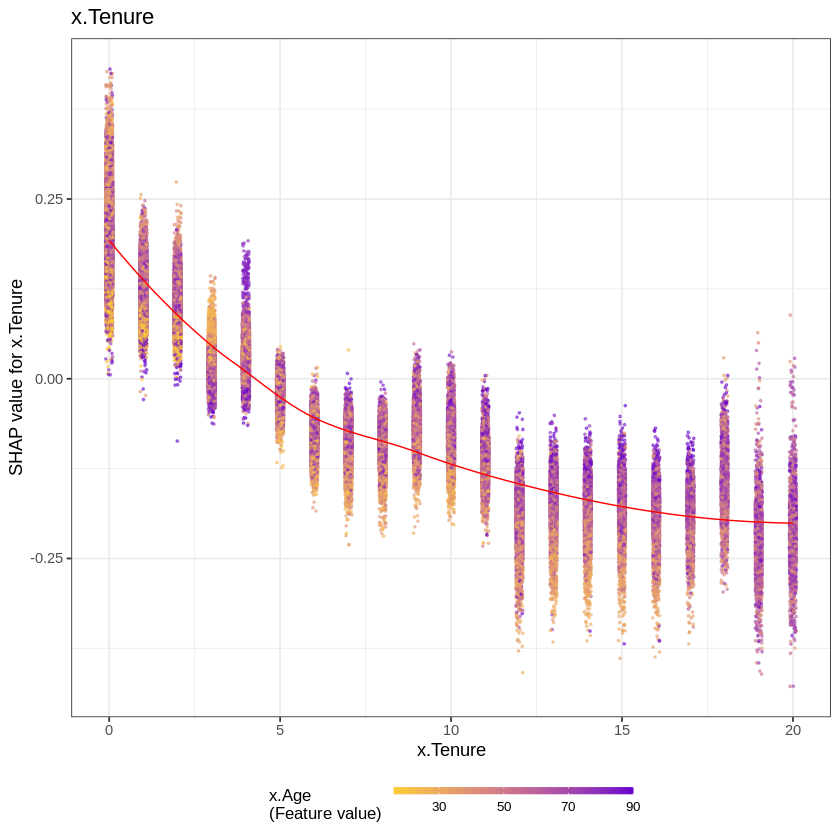

`geom_smooth()` using formula = 'y ~ x'


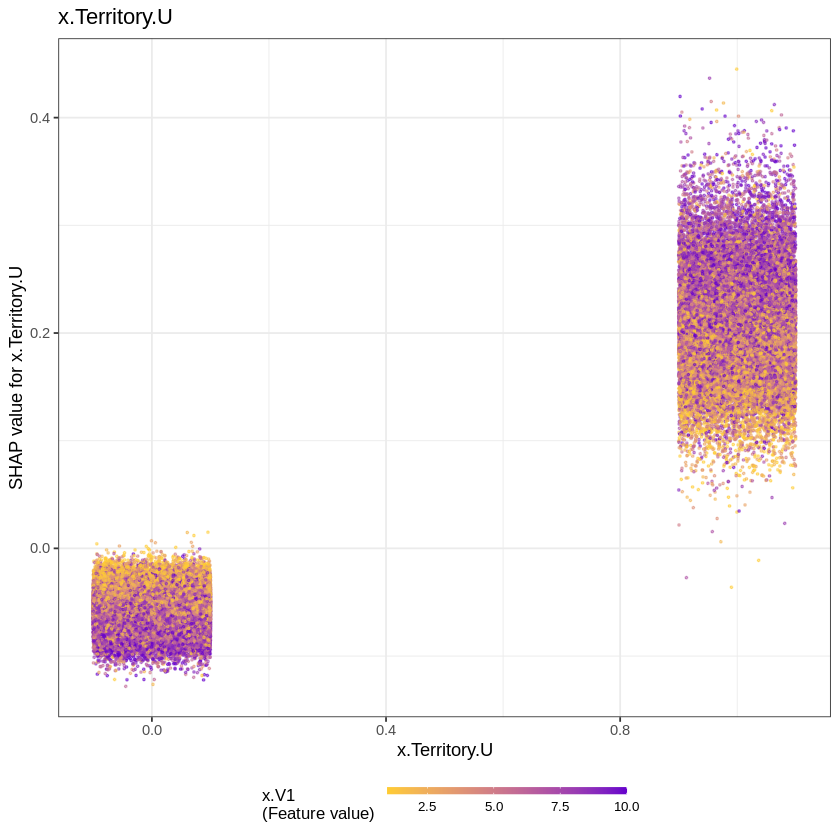

`geom_smooth()` using formula = 'y ~ x'


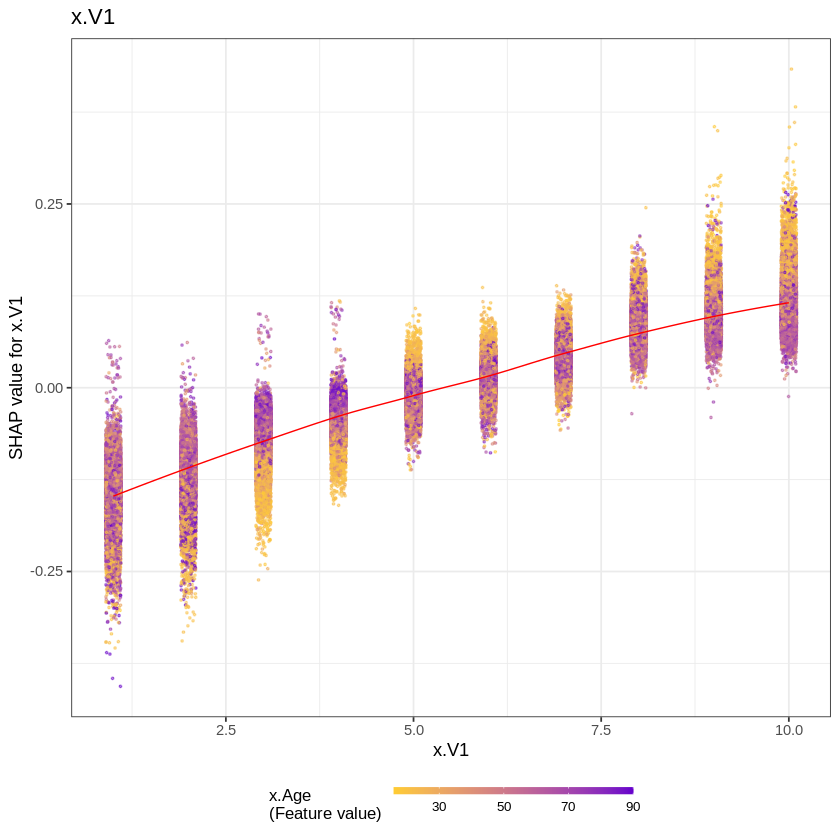

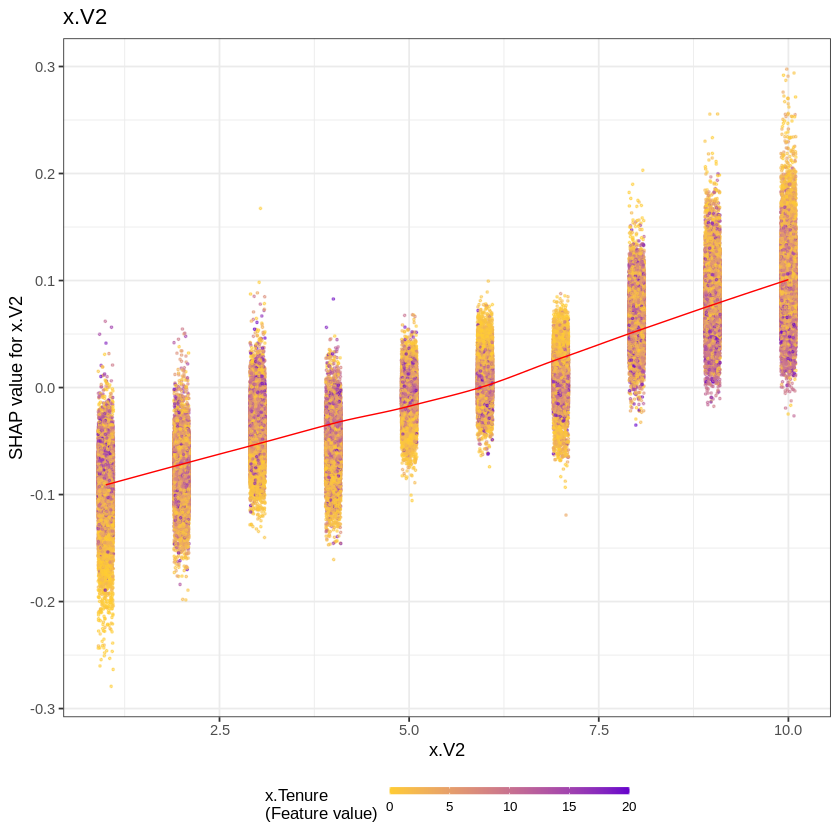

In [34]:
imp_vars <- shap.importance(shap, top_n = 5, names_only = TRUE)

# Plot dependence plots for top 5 predictor variables
# The color feature selects the 
for (v in imp_vars) {
  p <- shap.plot.dependence(shap, v, color_feature = "auto",
                            alpha = 0.5, jitter_width = 0.1) +
    ggtitle(v)
  print(p)
}

`geom_smooth()` using formula = 'y ~ x'


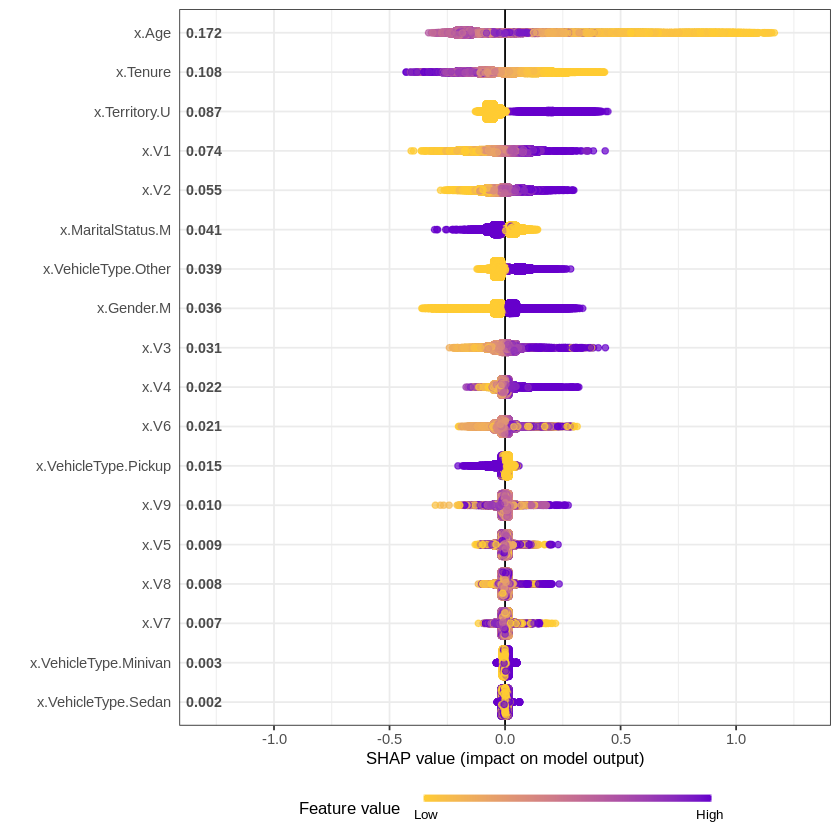

`geom_smooth()` using formula = 'y ~ x'


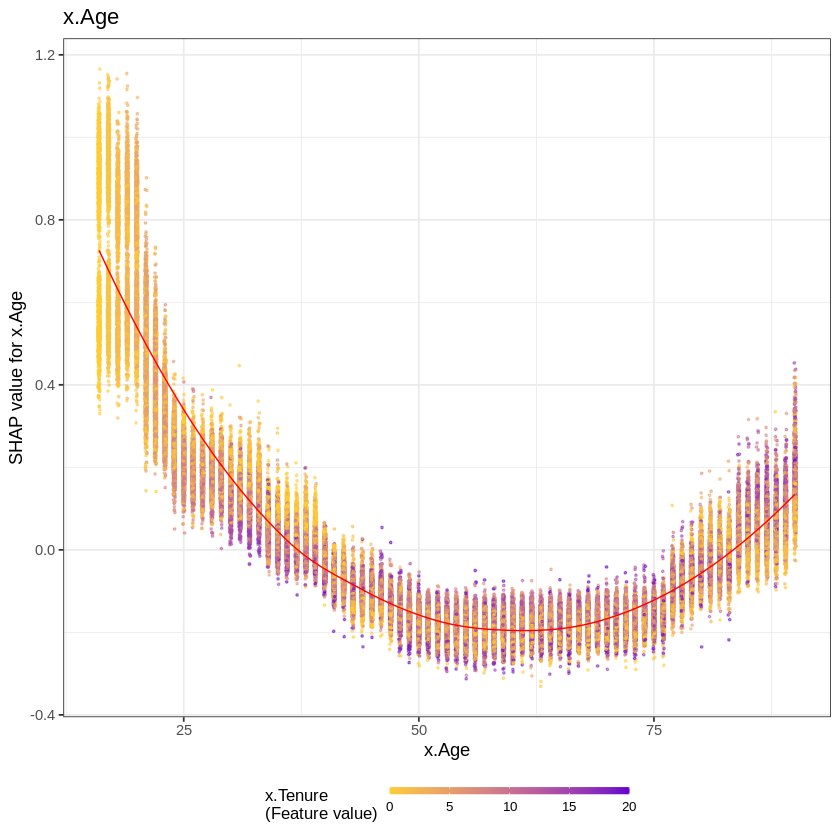

`geom_smooth()` using formula = 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“at  -0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“radius  2.5e-05”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“all data on boundary of neighborhood. make span bigger”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  1”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1.01”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“zero-wid

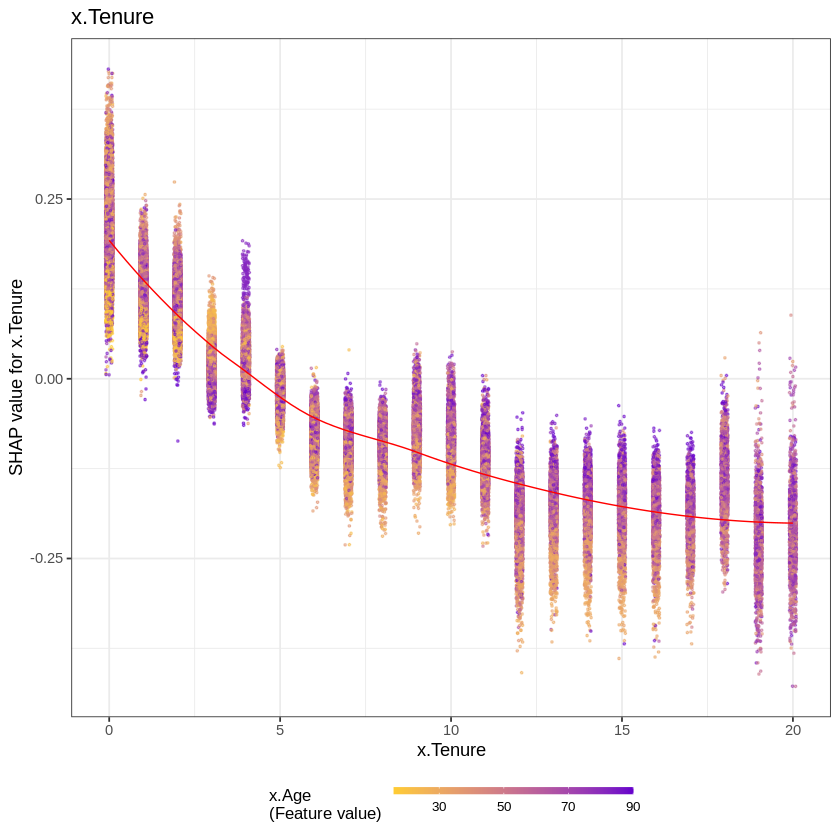

`geom_smooth()` using formula = 'y ~ x'


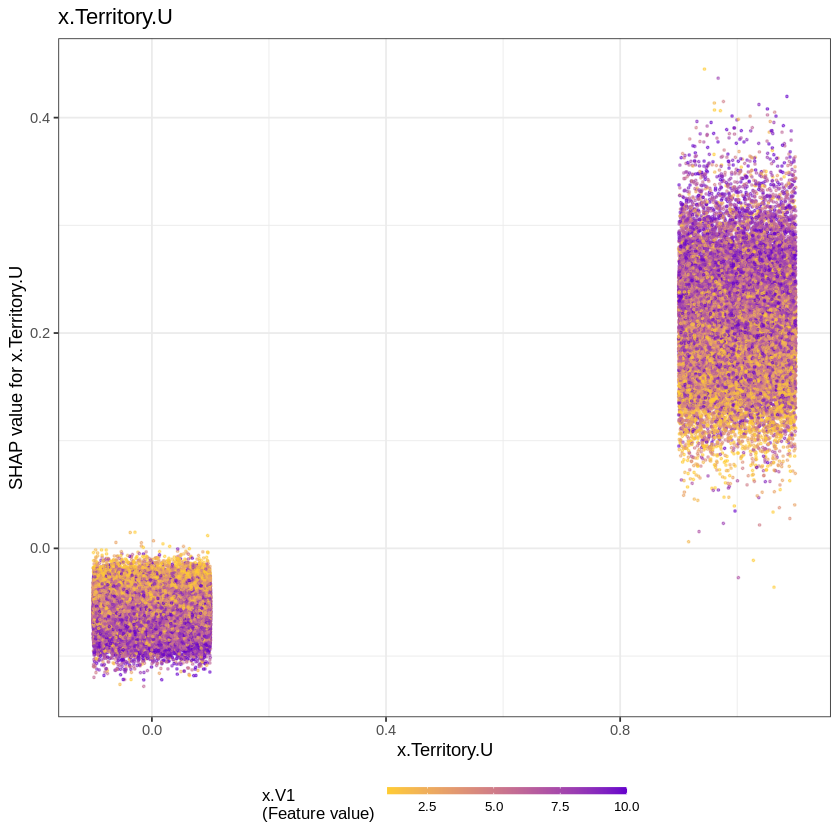

`geom_smooth()` using formula = 'y ~ x'


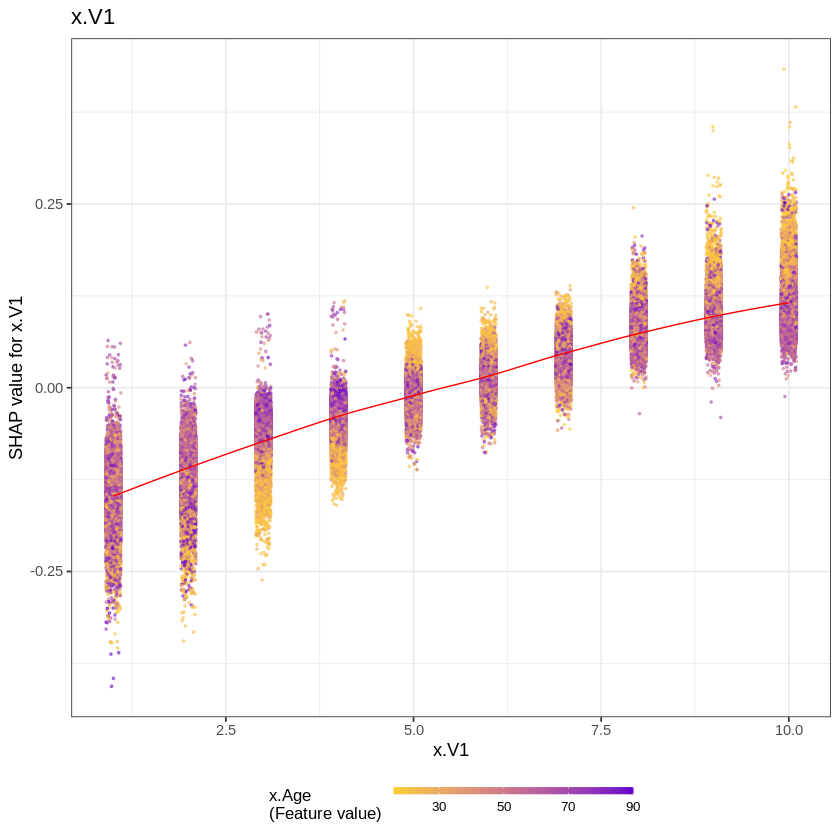

`geom_smooth()` using formula = 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 1.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  7.2547e-28”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1.01”


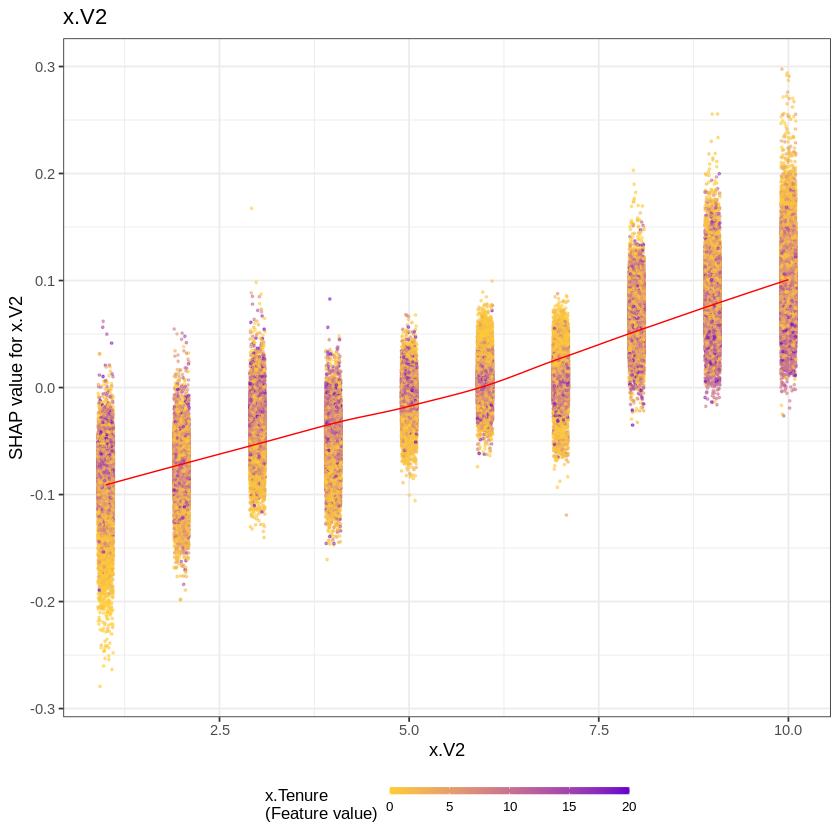

`geom_smooth()` using formula = 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 1.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  2.7738e-27”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1.01”


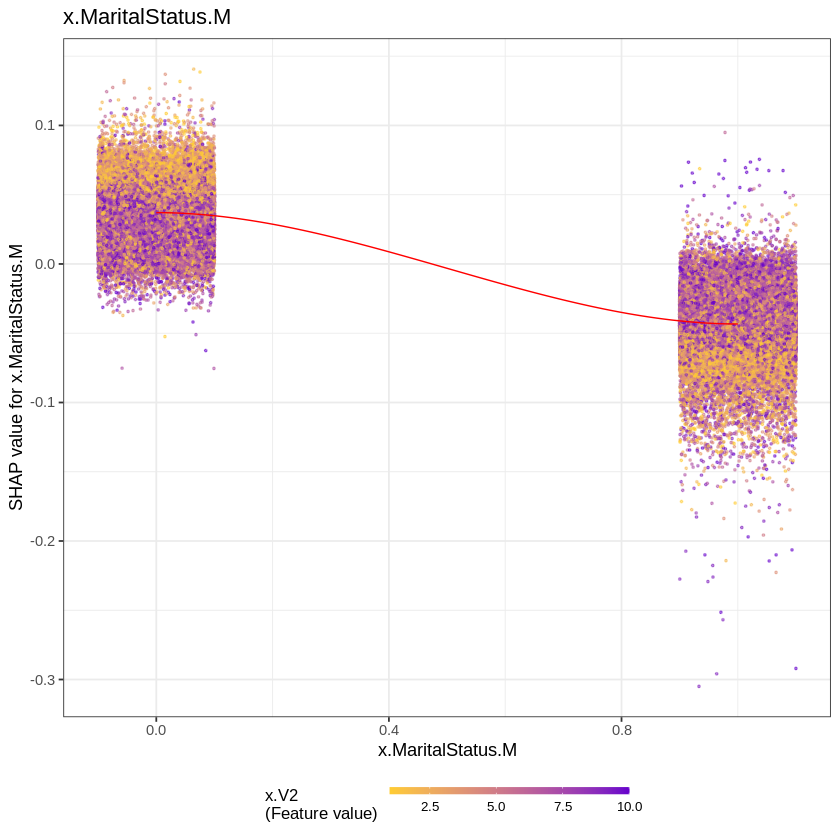

`geom_smooth()` using formula = 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 1.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  4.1288e-28”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1.01”


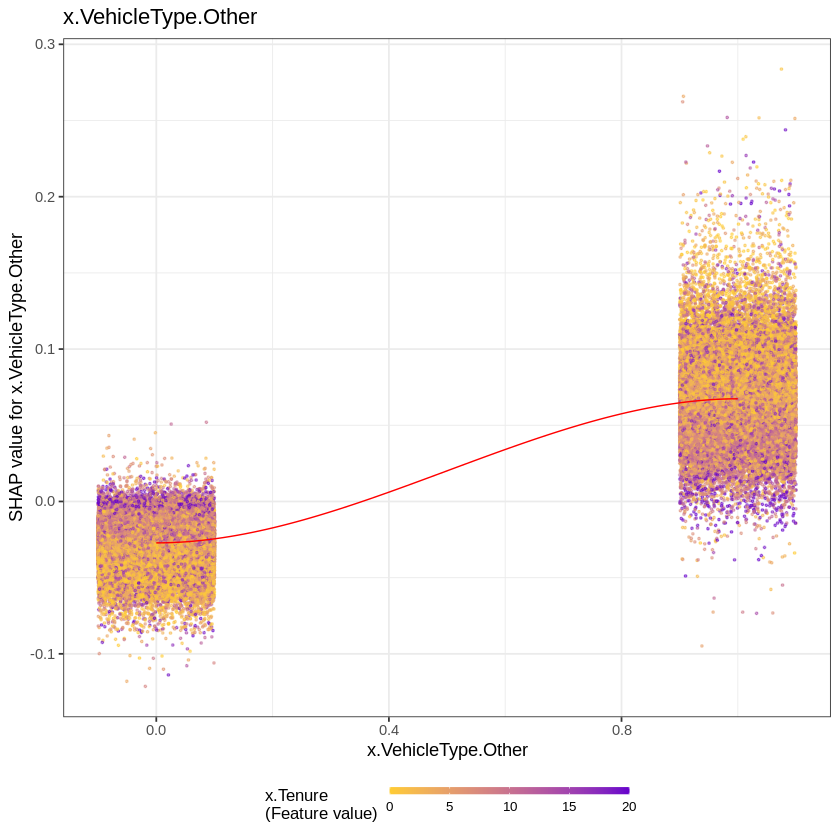

`geom_smooth()` using formula = 'y ~ x'


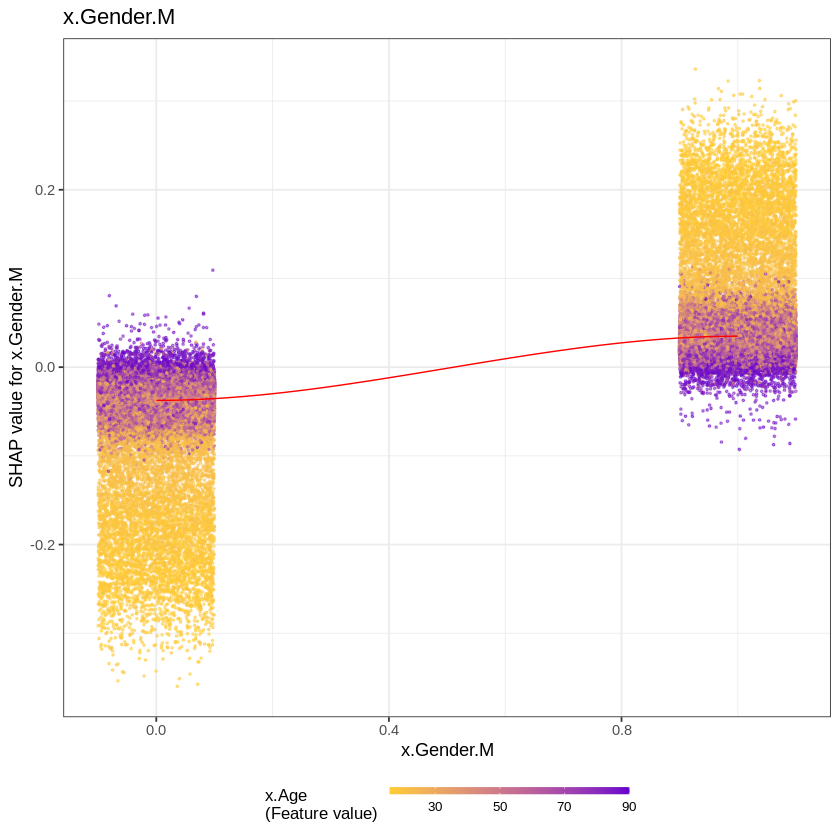

`geom_smooth()` using formula = 'y ~ x'


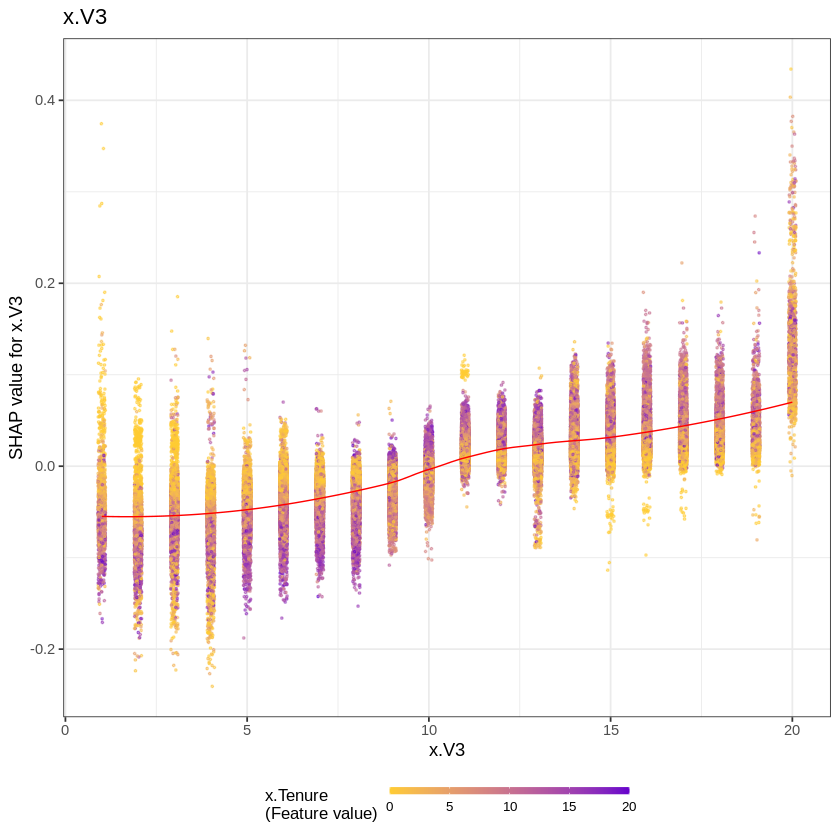

`geom_smooth()` using formula = 'y ~ x'


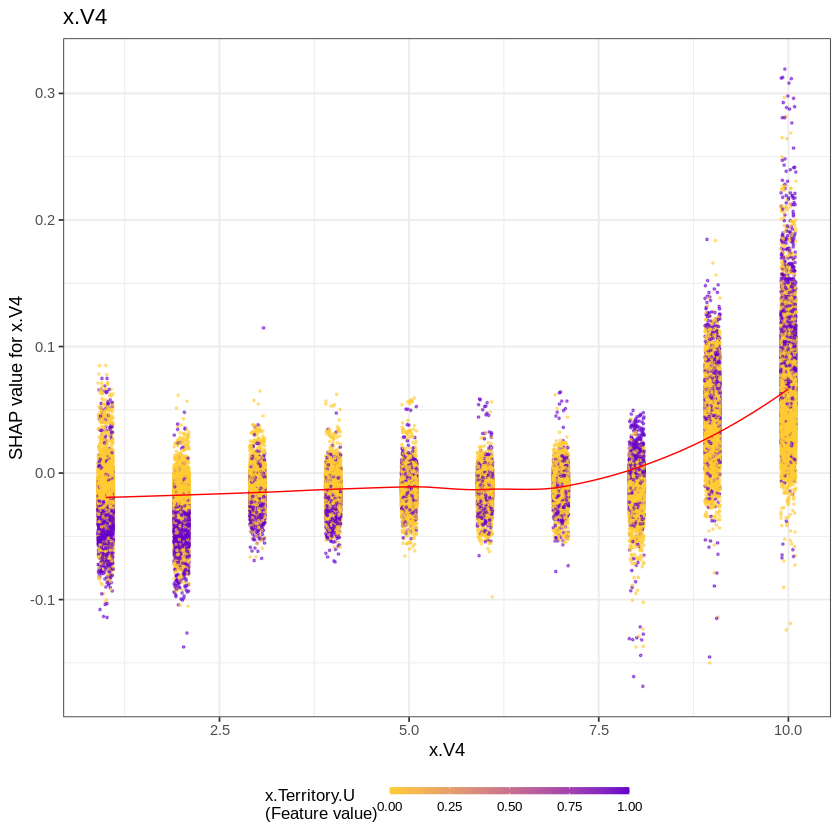

In [32]:

# Loop over dependence plots in decreasing importance
for (v in shap.importance(shap, names_only = TRUE)) {
  p <- shap.plot.dependence(shap, v, color_feature = "auto", 
                            alpha = 0.5, jitter_width = 0.1) +
    ggtitle(v)
  print(p)
}

# Hyper parameter tuning

Here we are trying to go through following variables 

* nrounds : 3,5,10
* max_depth : 1,2,3
* eta : 0.3, 0.5
* gamma :  0.1,0.3
* subsample: 0.6, 0.8
* colsample_bytree : 0.6, 0.8

In [ ]:
# Define the hyperparameters grid
hyperparams <- data.frame(
  nrounds = c(5, 7),
  max_depth = c(3,6),
  eta = c(0.1, 0.2),
  gamma = c(0, 1),
  subsample = c(0.6, 0.8),
  colsample_bytree = c(0.6, 0.8)
)

# Initialize a list to store the AUC values for each set of hyperparameters
auc_list <- list()

# Add data and quiet settings
quiet.setting = TRUE
dtrain <- xgb.DMatrix(data = as.matrix(x.train)
                        , label = y.train
  )

# Loop through each set of hyperparameters
for (i in 1:nrow(hyperparams)) {
  
  
  params <- as.list(hyperparams[i, ]) # Get the current set of hyperparameters
  
  # Run cross-validation with the current set of hyperparameters
  cv_results <- xgb.cv(
    data = dtrain,
    nfold = 2,
    nrounds = params$nrounds,
    max_depth = params$max_depth,
    eta = params$eta,
    gamma = params$gamma,
    subsample = params$subsample,
    colsample_bytree = params$colsample_bytree,
    objective = "binary:logistic",
    eval_metric = "auc"
  )
  
  auc_list[[i]] <- max(cv_results$evaluation_log$test_auc_mean) # Store the maximum AUC value for the current set of hyperparameters

  cat("Hyperparameters:", i, " - ", paste(names(params), unlist(params), sep = " = "), "\n")
  cat("AUC value:", auc_list[[i]], "\n\n") # Print the current set of hyperparameters and its corresponding AUC value
}

best_index <- which.max(unlist(auc_list)) # Extract the index of the best set of hyperparameters (i.e., the set with the highest AUC value)


best_params <- hyperparams[best_index, ] # Extract the best set of hyperparameters and its corresponding AUC value
best_auc <- auc_list[[best_index]]

cat("Best Hyperparameters:", paste(names(best_params), unlist(best_params), sep = " = "), "\n")
cat("Best AUC value:", best_auc, "\n") # Print the best set of hyperparameters and its corresponding AUC value


In [ ]:
params = list(eta=0.1,
  max_depth=6,
  subsample=1,
  colsample_bytree=1)
start.time <- Sys.time()
xgb.cv.out <- xgb.cv(params = params,
  data = as.matrix(x.train),
  label = y.train,
  objective = "binary:logistic",
  nrounds = 100,
  nfold = 5,
  early_stop_round = 10,
  verbose = 0)
end.time <- Sys.time()
end.time - start.time

In [ ]:
df.cv <- xgb.cv.out$evaluation_log
plot(df.cv$iter, df.cv$train_logloss_mean, type = "l", lty=1)
lines(df.cv$iter, df.cv$test_logloss_mean, lty=2)
best.iter <- df.cv$iter[df.cv$test_logloss_mean == min(df.cv$test_logloss_mean)]
abline(v=best.iter)
text(60, 0.5, paste("best.iter = ", best.iter))

In [ ]:
m.xgb3 <- xgboost(data = as.matrix(x.train),
  label = y.train,
  objective = "binary:logistic",
  eta = 0.1,
  nrounds = 46,
  verbose = 0)
df.train$y.pred.xgb3 <- predict(m.xgb3, newdata=as.matrix(x.train), type="response")
df.test$y.pred.xgb3 <- predict(m.xgb3, newdata=as.matrix(x.test), type="response")

In [ ]:
statline.xgb3 <- build_statline(y.train, df.train$y.pred.xgb3, y.test, df.test$y.pred.xgb3, "XGB3")
statline.all <- rbind(statline.glm, statline.xgb, statline.xgb2, statline.xgb3)
statline.all

Got another step here. We'll make a final step, and sample on variables and features. This will generally help mitigate overfitting as well as increase the chance for variables to shine if they are meaningful relative to the response.

In [ ]:
params = list(eta=0.1,
  max_depth=6,
  subsample=0.6,
  colsample_bytree=0.6)
start.time <- Sys.time()
xgb.cv.out <- xgb.cv(params = params,
  data = as.matrix(x.train),
  label = y.train,
  objective = "binary:logistic",
  nrounds = 200,
  nfold = 5,
  early_stop_round = 10,
  verbose = 0)
end.time <- Sys.time()
end.time - start.time

In [ ]:
df.cv <- xgb.cv.out$evaluation_log
plot(df.cv$iter, df.cv$train_logloss_mean, type = "l", lty=1)
lines(df.cv$iter, df.cv$test_logloss_mean, lty=2)
best.iter <- df.cv$iter[df.cv$test_logloss_mean == min(df.cv$test_logloss_mean)]
abline(v=best.iter)
text(70, 0.5, paste("best.iter = ", best.iter))

In [ ]:
m.xgb4 <- xgboost(data = as.matrix(x.train),
  label = y.train,
  objective = "binary:logistic",
  eta = 0.1,
  subsample=0.6,
  colsample_bytree=0.6,
  nrounds = 48,
  verbose = 0)
df.train$y.pred.xgb4 <- predict(m.xgb4, newdata=as.matrix(x.train), type="response")
df.test$y.pred.xgb4 <- predict(m.xgb4, newdata=as.matrix(x.test), type="response")

In [ ]:
statline.xgb4 <- build_statline(y.train, df.train$y.pred.xgb4, y.test, df.test$y.pred.xgb4, "XGB4")
statline.all <- rbind(statline.glm, statline.xgb, statline.xgb2, statline.xgb3, statline.xgb4)
statline.all

In [ ]:
xgb.importance(colnames(x.train), model = m.xgb4)

In [ ]:
quiet.setting = TRUE
roc.score.glm <- roc(y.train, df.train$y.pred.glm, quiet = quiet.setting)
roc.score.xgb <- roc(y.train, df.train$y.pred.xgb, quiet = quiet.setting)
roc.score.xgb2 <- roc(y.train, df.train$y.pred.xgb2, quiet = quiet.setting)
roc.score.xgb3 <- roc(y.train, df.train$y.pred.xgb3, quiet = quiet.setting)
roc.score.xgb4 <- roc(y.train, df.train$y.pred.xgb4, quiet = quiet.setting)
plot(roc.score.glm, col = "blue", add = FALSE)
plot(roc.score.xgb, col = "purple", lty = 1, add = TRUE)
plot(roc.score.xgb2, col = "purple", lty = 2, add = TRUE)
plot(roc.score.xgb3, col = "purple", lty = 3, add = TRUE)
plot(roc.score.xgb4, col = "purple", lty = 4, add = TRUE)
legend("topleft",
       legend=c("glm", "xgb1", "xgb2", "xgb3", "xgb4"),
       lty=c(1,1:4),
       col=c("blue", "purple", "purple", "purple", "purple"))

roc.score.glm <- roc(y.test, df.test$y.pred.glm, quiet = quiet.setting)
roc.score.xgb <- roc(y.test, df.test$y.pred.xgb, quiet = quiet.setting)
roc.score.xgb2 <- roc(y.test, df.test$y.pred.xgb2, quiet = quiet.setting)
roc.score.xgb3 <- roc(y.test, df.test$y.pred.xgb3, quiet = quiet.setting)
roc.score.xgb4 <- roc(y.test, df.test$y.pred.xgb4, quiet = quiet.setting)
plot(roc.score.glm, col = "blue", add = FALSE)
plot(roc.score.xgb, col = "purple", lty = 1, add = TRUE)
plot(roc.score.xgb2, col = "purple", lty = 2, add = TRUE)
plot(roc.score.xgb3, col = "purple", lty = 3, add = TRUE)
plot(roc.score.xgb4, col = "purple", lty = 4, add = TRUE)
legend("topleft",
       legend=c("glm", "xgb1", "xgb2", "xgb3", "xgb4"),
       lty=c(1,1:4),
       col=c("blue", "purple", "purple", "purple", "purple"))

In [ ]:
df.train <- df.train %>%
  mutate(nt = ntile(y.pred.xgb4, 10))
avse.plot.classification(var="nt",data=df.train,actual="y.out",pred="y.pred.xgb4",weight="exposures",lt_text="exposures",rt_text="freq")

df.test <- df.test %>%
  mutate(nt = ntile(y.pred.xgb4, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.xgb4",weight="exposures",lt_text="exposures",rt_text="freq")

In [ ]:
colnames(df.train)

In [ ]:
avse.plot.classification(var="x.Age",data=df.train,actual="y.out",pred="y.pred.xgb4",weight="exposures",lt_text="exposures",rt_text="freq")

Next, let's go to a third example, this time another step closer to real world data. See you in the next notebook!

# End

# References 